# 03. Machine Learning Classifier

This notebook implements a binary machine learning pipeline for content moderation that classifies text as either **toxic** or **safe** only.

## 🎯 Key Features:
1. **Binary Classification**: Only toxic vs safe (spam handled by rule-based filter)
2. **Hybrid Approach**: Combines TF-IDF text features with numerical toxicity scores
3. **Feature Integration**: Uses toxicity, overall_toxicity, and text characteristics from preprocessing
4. **Multiple Models**: Trains and compares various ML algorithms with anti-overfitting measures
5. **Individual Model Testing**: Tests each model individually for performance evaluation
6. **Risk Assessment Ready**: Designed for integration with rule-based filter

## 📊 Data Sources:
- **Text Features**: TF-IDF vectorization of processed text
- **Numerical Features**: toxicity, overall_toxicity, and 11 text characteristics
- **Labels**: Binary classification (toxic/safe) derived from toxicity thresholds

## 🔄 Integration Plan:
- **ML Model**: Handles toxic vs safe classification
- **Rule-Based Filter**: Handles spam detection separately
- **Risk Assessment Engine**: Will combine both systems for final decision


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Load Processed Data


In [2]:
# Load RAW data for better ML training
print("🔄 NEW APPROACH: Loading raw all_data.csv...")
df = pd.read_csv('all_data.csv')
print(f"Raw dataset loaded successfully! Shape: {df.shape}")

# Display basic information
print("\nDataset Info:")
print(f"Columns: {list(df.columns)}")

# Check for missing values in key columns
print(f"\nMissing values in key columns:")
key_cols = ['comment_text', 'toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat']
print(df[key_cols].isnull().sum())

# Create binary labels based on raw toxicity scores
print("\n🎯 Creating better toxicity labeling strategy...")
print(f"Toxicity range: {df['toxicity'].min():.4f} - {df['toxicity'].max():.4f}")
print(f"Severe toxicity range: {df['severe_toxicity'].min():.4f} - {df['severe_toxicity'].max():.4f}")
print(f"Insult range: {df['insult'].min():.4f} - {df['insult'].max():.4f}")

# Strategy: Use multiple toxicity indicators for better labeling
TOXICITY_THRESHOLD = 0.25  # Texts with toxicity >= 0.25 are considered toxic
SEVERE_TOXICITY_THRESHOLD = 0.2  # Texts with severe_toxicity >= 0.2 are considered toxic
INSULT_THRESHOLD = 0.3  # Texts with insult >= 0.3 are considered toxic

# Create binary labels using multiple criteria
df['binary_label'] = (
    (df['toxicity'] >= TOXICITY_THRESHOLD) | 
    (df['severe_toxicity'] >= SEVERE_TOXICITY_THRESHOLD) | 
    (df['insult'] >= INSULT_THRESHOLD)
).astype(int)
df['label_name'] = df['binary_label'].map({0: 'safe', 1: 'toxic'})

print(f"\nBinary label distribution (multiple criteria):")
print(df['label_name'].value_counts())
print(f"\nBinary label proportions:")
print(df['label_name'].value_counts(normalize=True))

# Display toxicity score distributions by label
print(f"\nToxicity score distributions:")
print(f"Safe texts - Toxicity: {df[df['binary_label'] == 0]['toxicity'].describe()}")
print(f"Toxic texts - Toxicity: {df[df['binary_label'] == 1]['toxicity'].describe()}")

print(f"\nSevere toxicity score distributions:")
print(f"Safe texts - Severe Toxicity: {df[df['binary_label'] == 0]['severe_toxicity'].describe()}")
print(f"Toxic texts - Severe Toxicity: {df[df['binary_label'] == 1]['severe_toxicity'].describe()}")

# Show breakdown of toxic labels
toxic_by_toxicity = (df['toxicity'] >= TOXICITY_THRESHOLD).sum()
toxic_by_severe = (df['severe_toxicity'] >= SEVERE_TOXICITY_THRESHOLD).sum()
toxic_by_insult = (df['insult'] >= INSULT_THRESHOLD).sum()

print(f"\nToxic label breakdown:")
print(f"Toxic by toxicity >= {TOXICITY_THRESHOLD}: {toxic_by_toxicity:,}")
print(f"Toxic by severe_toxicity >= {SEVERE_TOXICITY_THRESHOLD}: {toxic_by_severe:,}")
print(f"Toxic by insult >= {INSULT_THRESHOLD}: {toxic_by_insult:,}")
print(f"Total toxic (any criterion): {df['binary_label'].sum():,}")



🔄 NEW APPROACH: Loading raw all_data.csv...
Raw dataset loaded successfully! Shape: (1999516, 46)

Dataset Info:
Columns: ['id', 'comment_text', 'split', 'created_date', 'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow', 'sad', 'likes', 'disagree', 'toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat', 'male', 'female', 'transgender', 'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation', 'christian', 'jewish', 'muslim', 'hindu', 'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian', 'latino', 'other_race_or_ethnicity', 'physical_disability', 'intellectual_or_learning_disability', 'psychiatric_or_mental_illness', 'other_disability', 'identity_annotator_count', 'toxicity_annotator_count']

Missing values in key columns:
comment_text       4
toxicity           0
severe_toxicity    0
obscene            0
sexual_explicit    0
identity_attack    0
insult             0


## 2. Data Preparation and TF-IDF Vectorization


In [3]:
# RAW DATA APPROACH: Using full dataset with simple preprocessing (fixed to avoid leakage)
print("🚀 RAW DATA: Using full dataset with simple preprocessing (no leakage)...")

# Use full dataset (no sampling for now)
X_text = df['comment_text'].fillna('')
y = df['binary_label']

print(f"Full dataset size: {len(X_text)}")
print(f"Label distribution: {y.value_counts().to_dict()}")
print(f"Label proportions: {y.value_counts(normalize=True).to_dict()}")

# Simple text preprocessing
print("\n🔧 Applying simple text preprocessing...")
import re

def simple_preprocess(text):
    """Simple text preprocessing for ML training"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^\w\s\.\!\?]', '', text)
    
    return text.strip()

# Apply preprocessing
X_text_processed = X_text.apply(simple_preprocess)
print(f"Text preprocessing completed!")

# 1) Split BEFORE vectorization to avoid leakage
X_text_trainval, X_text_test, y_trainval, y_test = train_test_split(
    X_text_processed, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_text_train, X_text_val, y_train, y_val = train_test_split(
    X_text_trainval, y_trainval,
    test_size=0.2,  # 20% of remaining 80% = 16% of total
    random_state=42,
    stratify=y_trainval
)

print(f"\nTraining texts: {len(X_text_train)}")
print(f"Validation texts: {len(X_text_val)}")
print(f"Test texts: {len(X_text_test)}")

# 2) Define NON-leaky numerical features (do NOT include toxicity-derived targets)
# Remove direct target/label-origin features to prevent leakage
leaky_cols = ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat']

# If you still want auxiliary numeric features, derive them only from text length etc.
# Keep it empty for now to be safe; can be reintroduced later with proper derivation
numerical_features = []

from scipy.sparse import hstack

# 3) Vectorize: fit on train ONLY, transform val/test
print("\nCreating TF-IDF vectors (fit on train only)...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words='english'
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_text_train)
X_val_tfidf = tfidf_vectorizer.transform(X_text_val)
X_test_tfidf = tfidf_vectorizer.transform(X_text_test)

print(f"TF-IDF train shape: {X_train_tfidf.shape}")
print(f"TF-IDF val shape:   {X_val_tfidf.shape}")
print(f"TF-IDF test shape:  {X_test_tfidf.shape}")

# 4) Combine with numerical features if any
if len(numerical_features) > 0:
    X_numerical_train = df.loc[X_text_train.index, numerical_features].fillna(0).values
    X_numerical_val = df.loc[X_text_val.index, numerical_features].fillna(0).values
    X_numerical_test = df.loc[X_text_test.index, numerical_features].fillna(0).values

    X_train = hstack([X_train_tfidf, X_numerical_train])
    X_val = hstack([X_val_tfidf, X_numerical_val])
    X_test = hstack([X_test_tfidf, X_numerical_test])
else:
    X_train, X_val, X_test = X_train_tfidf, X_val_tfidf, X_test_tfidf

# Store feature names for later use
feature_names = list(tfidf_vectorizer.get_feature_names_out()) + numerical_features
print(f"\nTotal features: {len(feature_names)}")
print(f"TF-IDF features: {len(tfidf_vectorizer.get_feature_names_out())}")
print(f"Numerical features: {len(numerical_features)}")

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training label distribution: {np.bincount(y_train)}")
print(f"Validation label distribution: {np.bincount(y_val)}")
print(f"Test label distribution: {np.bincount(y_test)}")


🚀 RAW DATA: Using full dataset with simple preprocessing (no leakage)...
Full dataset size: 1999516
Label distribution: {0: 1696820, 1: 302696}
Label proportions: {0: 0.8486153649183102, 1: 0.15138463508168976}

🔧 Applying simple text preprocessing...
Text preprocessing completed!

Training texts: 1279689
Validation texts: 319923
Test texts: 399904

Creating TF-IDF vectors (fit on train only)...
TF-IDF train shape: (1279689, 10000)
TF-IDF val shape:   (319923, 10000)
TF-IDF test shape:  (399904, 10000)

Total features: 10000
TF-IDF features: 10000
Numerical features: 0

Training set size: 1279689
Validation set size: 319923
Test set size: 399904
Training label distribution: [1085963  193726]
Validation label distribution: [271492  48431]
Test label distribution: [339365  60539]


## 3. Train Multiple Models


In [15]:
# ANTI-OVERFITTING MODEL SET: Simplified models with strong regularization
print("🛡️ ANTI-OVERFITTING MODEL SET: Training simplified models with strong regularization...")
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    'Naive Bayes': MultinomialNB(alpha=10.0),  # Strong smoothing to prevent overfitting
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced', C=0.1),  # Strong regularization (C=0.1)
    'Linear SVM': CalibratedClassifierCV(LinearSVC(random_state=42, class_weight='balanced', max_iter=2000), cv=3),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=10, min_samples_split=100, min_samples_leaf=50),  # Strong regularization
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=50, max_depth=10, min_samples_split=100, min_samples_leaf=50, max_features='sqrt'),  # Strong regularization
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]), max_depth=3, learning_rate=0.05, n_estimators=50, subsample=0.7, colsample_bytree=0.7, reg_alpha=1.0, reg_lambda=1.0)  # Strong regularization
}

# Train and evaluate models
model_results = {}
trained_models = {}

print("Training binary classification models...")
print("=" * 60)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on test and validation sets
    y_pred_test = model.predict(X_test)
    y_pred_val = model.predict(X_val)
    # Some calibrated models need predict_proba; ensure it's available
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics for binary classification
    test_accuracy = accuracy_score(y_test, y_pred_test)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    f1_macro = f1_score(y_test, y_pred_test, average='macro')
    f1_weighted = f1_score(y_test, y_pred_test, average='weighted')
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    # Overfitting detection
    overfitting_gap = test_accuracy - val_accuracy
    is_overfitting = overfitting_gap > 0.05  # More than 5% gap indicates overfitting
    
    # Store results
    model_results[name] = {
        'test_accuracy': test_accuracy,
        'val_accuracy': val_accuracy,
        'overfitting_gap': overfitting_gap,
        'is_overfitting': is_overfitting,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred_test,
        'probabilities': y_pred_proba
    }
    
    trained_models[name] = model
    
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Val Accuracy: {val_accuracy:.4f}")
    print(f"Overfitting Gap: {overfitting_gap:.4f} {'🚨 OVERFITTING!' if is_overfitting else '✅ Good'}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")
    print(f"CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # 🔍 Simple test: Check if model can distinguish between classes
    unique_predictions = len(np.unique(y_pred_test))
    print(f"Unique predictions: {unique_predictions} {'✅ Learning!' if unique_predictions > 1 else '🚨 NOT LEARNING!'}")
    
    # Test on simple examples
    print("\n🧪 Testing on simple examples:")
    test_examples = [
        "This is a nice comment",
        "You are stupid and I hate you"
    ]
    
    for example in test_examples:
        # Preprocess the example text
        example_processed = simple_preprocess(example)
        
        # Create TF-IDF features
        example_tfidf = tfidf_vectorizer.transform([example_processed])
        
        if len(numerical_features) > 0:
            # Create numerical features (zeros for testing)
            example_numerical = np.zeros((1, len(numerical_features)))
            # Combine features (same as training)
            example_combined = hstack([example_tfidf, example_numerical])
        else:
            example_combined = example_tfidf
        
        example_pred = model.predict(example_combined)[0]
        example_proba = model.predict_proba(example_combined)[0]
        result = "TOXIC" if example_pred == 1 else "SAFE"
        print(f"  '{example}' -> {result} (Safe={example_proba[0]:.3f}, Toxic={example_proba[1]:.3f})")

print("\nAll models trained successfully!")


🛡️ ANTI-OVERFITTING MODEL SET: Training simplified models with strong regularization...
Training binary classification models...

Training Naive Bayes...
Test Accuracy: 0.8679
Val Accuracy: 0.8678
Overfitting Gap: 0.0001 ✅ Good
F1 Score (Macro): 0.5874
F1 Score (Weighted): 0.8246
CV Score: 0.8670 (+/- 0.0004)
Unique predictions: 2 ✅ Learning!

🧪 Testing on simple examples:
  'This is a nice comment' -> SAFE (Safe=0.877, Toxic=0.123)
  'You are stupid and I hate you' -> TOXIC (Safe=0.098, Toxic=0.902)

Training Logistic Regression...
Test Accuracy: 0.8530
Val Accuracy: 0.8539
Overfitting Gap: -0.0009 ✅ Good
F1 Score (Macro): 0.7599
F1 Score (Weighted): 0.8641
CV Score: 0.8534 (+/- 0.0013)
Unique predictions: 2 ✅ Learning!

🧪 Testing on simple examples:
  'This is a nice comment' -> SAFE (Safe=0.755, Toxic=0.245)
  'You are stupid and I hate you' -> TOXIC (Safe=0.000, Toxic=1.000)

Training Linear SVM...
Test Accuracy: 0.8998
Val Accuracy: 0.9000
Overfitting Gap: -0.0002 ✅ Good
F1 Score 

## 4. Model Evaluation and Comparison


In [16]:
# Create model comparison table with overfitting detection
comparison_data = []
for name, results in model_results.items():
    comparison_data.append({
        'Model': name,
        'Test Acc': results['test_accuracy'],
        'Val Acc': results['val_accuracy'],
        'Overfit Gap': results['overfitting_gap'],
        'Overfitting': '🚨 YES' if results['is_overfitting'] else '✅ NO',
        'F1 Macro': results['f1_macro'],
        'F1 Weighted': results['f1_weighted'],
        'CV Mean': results['cv_mean'],
        'CV Std': results['cv_std']
    })

comparison_df = pd.DataFrame(comparison_data)
# Sort by Val Acc primarily, then Test Acc
comparison_df = comparison_df.sort_values(['Val Acc', 'Test Acc'], ascending=False)

print("Binary Classification Model Performance Comparison (with Overfitting Detection):")
print("=" * 100)
print(comparison_df.to_string(index=False, float_format='%.4f'))

# Find best models (prioritizing non-overfitting models and validation performance)
non_overfitting_models = comparison_df[comparison_df['Overfitting'] == '✅ NO']
if len(non_overfitting_models) > 0:
    best_model = non_overfitting_models.iloc[0]
    print(f"\n🏆 Best Non-Overfitting Model: {best_model['Model']} (Val Acc: {best_model['Val Acc']:.4f})")
else:
    best_model = comparison_df.iloc[0]
    print(f"\n⚠️ All models show overfitting. Best overall: {best_model['Model']} (Val Acc: {best_model['Val Acc']:.4f})")

# Overfitting summary
overfitting_count = sum(1 for results in model_results.values() if results['is_overfitting'])
print(f"\n📊 Overfitting Summary:")
print(f"Models with overfitting: {overfitting_count}/{len(model_results)}")
print(f"Models without overfitting: {len(model_results) - overfitting_count}/{len(model_results)}")

# Display class distribution in test set
print(f"\nTest Set Class Distribution:")
print(f"Safe: {np.sum(y_test == 0):,} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"Toxic: {np.sum(y_test == 1):,} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")


Binary Classification Model Performance Comparison (with Overfitting Detection):
              Model  Test Acc  Val Acc  Overfit Gap Overfitting  F1 Macro  F1 Weighted  CV Mean  CV Std
         Linear SVM    0.8998   0.9000      -0.0002        ✅ NO    0.7675       0.8898   0.8999  0.0005
        Naive Bayes    0.8679   0.8678       0.0001        ✅ NO    0.5874       0.8246   0.8670  0.0002
Logistic Regression    0.8530   0.8539      -0.0009        ✅ NO    0.7599       0.8641   0.8534  0.0007
            XGBoost    0.8264   0.8271      -0.0007        ✅ NO    0.6541       0.8243   0.8265  0.0008
      Random Forest    0.8273   0.8271       0.0002        ✅ NO    0.6993       0.8361   0.8262  0.0018
      Decision Tree    0.8215   0.8222      -0.0007        ✅ NO    0.6281       0.8151   0.8230  0.0001

🏆 Best Non-Overfitting Model: Linear SVM (Val Acc: 0.9000)

📊 Overfitting Summary:
Models with overfitting: 0/6
Models without overfitting: 6/6

Test Set Class Distribution:
Safe: 339,365 (8

In [17]:
## 3.5 Ensemble of Top 3 Models (by validation accuracy)
from sklearn.ensemble import VotingClassifier

print("\n🤝 Building soft-voting ensemble from top-3 models (by Val Acc)...")

# Rank models by validation accuracy
top_by_val = sorted(model_results.items(), key=lambda kv: kv[1]['val_accuracy'], reverse=True)

# Select top 3
top3 = top_by_val[:3]
print("Top 3 models:")
for name, res in top3:
    print(f" - {name}: Val Acc={res['val_accuracy']:.4f}")

# Create ensemble with probability voting
estimators = [(name, trained_models[name]) for name, _ in top3]
ensemble = VotingClassifier(estimators=estimators, voting='soft')

# Fit on train
ensemble.fit(X_train, y_train)

# Evaluate
y_pred_test = ensemble.predict(X_test)
y_pred_val = ensemble.predict(X_val)
y_pred_proba = ensemble.predict_proba(X_test)

test_accuracy = accuracy_score(y_test, y_pred_test)
val_accuracy = accuracy_score(y_val, y_pred_val)
f1_macro = f1_score(y_test, y_pred_test, average='macro')
f1_weighted = f1_score(y_test, y_pred_test, average='weighted')

cv_scores = cross_val_score(ensemble, X_train, y_train, cv=5, scoring='accuracy')

overfitting_gap = test_accuracy - val_accuracy
is_overfitting = overfitting_gap > 0.05

model_results['Ensemble'] = {
    'test_accuracy': test_accuracy,
    'val_accuracy': val_accuracy,
    'overfitting_gap': overfitting_gap,
    'is_overfitting': is_overfitting,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'predictions': y_pred_test,
    'probabilities': y_pred_proba
}
trained_models['Ensemble'] = ensemble

print(f"Ensemble Test Acc: {test_accuracy:.4f}")
print(f"Ensemble Val Acc:  {val_accuracy:.4f}")
print(f"Overfitting Gap:   {overfitting_gap:.4f} {'🚨 OVERFITTING!' if is_overfitting else '✅ Good'}")




🤝 Building soft-voting ensemble from top-3 models (by Val Acc)...
Top 3 models:
 - Linear SVM: Val Acc=0.9000
 - Naive Bayes: Val Acc=0.8678
 - Logistic Regression: Val Acc=0.8539
Ensemble Test Acc: 0.8993
Ensemble Val Acc:  0.8991
Overfitting Gap:   0.0002 ✅ Good


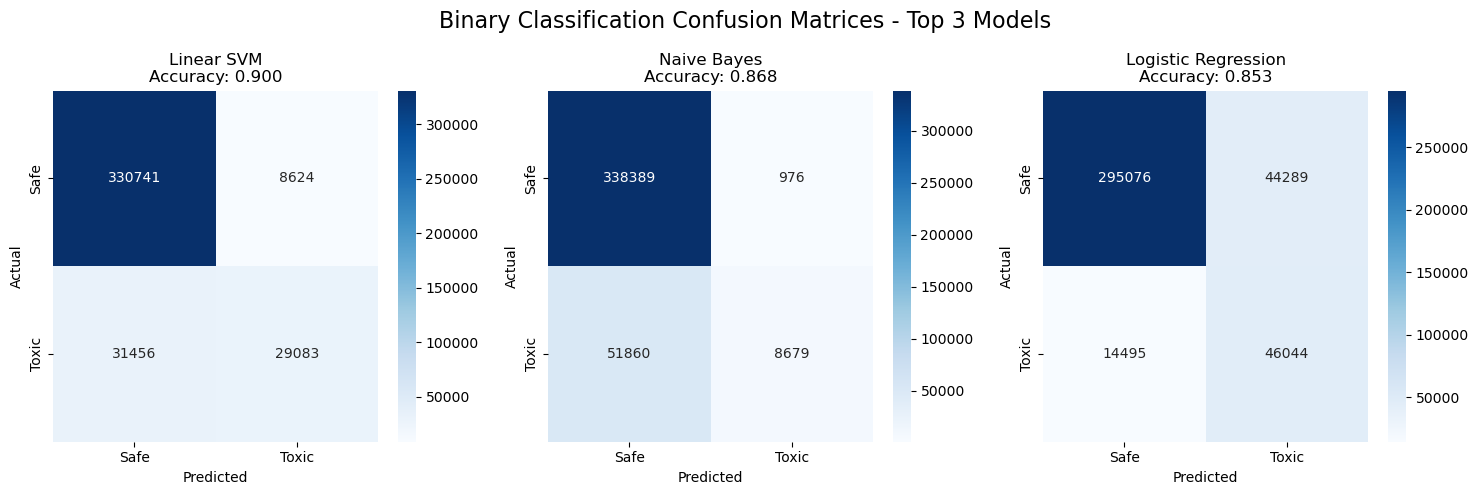


Feature Importance Analysis:

Decision Tree - Top 20 Most Important Features:
 1. stupid                         0.2333
 2. white                          0.1312
 3. trump                          0.1059
 4. idiot                          0.0855
 5. ignorant                       0.0845
 6. pathetic                       0.0751
 7. ridiculous                     0.0712
 8. racist                         0.0711
 9. dumb                           0.0595
10. idiots                         0.0573
11. liar                           0.0078
12. buffoon                        0.0043
13. fool                           0.0042
14. house                          0.0034
15. black                          0.0013
16. moron                          0.0006
17. black white                    0.0006
18. sexual                         0.0004
19. racists                        0.0003
20. according                      0.0003

Random Forest - Top 20 Most Important Features:
 1. stupid                      

In [18]:
# Create confusion matrices for top 3 models
top_3_models = comparison_df.head(3)['Model'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Binary Classification Confusion Matrices - Top 3 Models', fontsize=16)

class_names = ['Safe', 'Toxic']

for i, model_name in enumerate(top_3_models):
    y_pred = model_results[model_name]['predictions']
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names,
                yticklabels=class_names,
                ax=axes[i])
    # Use correct accuracy key based on model type
    accuracy_key = 'accuracy' if model_name == 'Ensemble' else 'test_accuracy'
    axes[i].set_title(f'{model_name}\nAccuracy: {model_results[model_name][accuracy_key]:.3f}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()


# Feature importance analysis for tree-based models
print(f"\nFeature Importance Analysis:")
print("=" * 50)

# Analyze feature importance for tree-based models
tree_models = ['Decision Tree', 'Random Forest', 'XGBoost']
for model_name in tree_models:
    if model_name in trained_models:
        model = trained_models[model_name]
        if hasattr(model, 'feature_importances_'):
            # Get top 20 most important features
            importance_scores = model.feature_importances_
            top_indices = np.argsort(importance_scores)[-20:][::-1]
            
            print(f"\n{model_name} - Top 20 Most Important Features:")
            for i, idx in enumerate(top_indices):
                if idx < len(feature_names):
                    print(f"{i+1:2d}. {feature_names[idx]:30s} {importance_scores[idx]:.4f}")
                else:
                    print(f"{i+1:2d}. Numerical Feature {idx-len(tfidf_vectorizer.get_feature_names_out()):2d} {importance_scores[idx]:.4f}")


# 5. Test

In [23]:
# Comprehensive test of Ensemble Model on sample texts
print("🧪 Testing Ensemble Model Performance on Sample Texts")
print("=" * 60)

# Test cases
test_texts = [
    "This is a normal comment about the weather.",
    "You are such an idiot and I hate you!",
    "I think this article is well-written and informative.",
    "This is complete bullshit and you're stupid!",
    "Thank you for sharing this interesting information.",
    "Great article, very informative and well-researched.",
    "You're a complete moron and should shut up!",
    "I disagree with your opinion but respect your right to express it.",
    "This is the worst thing I've ever read, you're an idiot!",
    "Interesting perspective, thanks for sharing your thoughts."
]

# Check if ensemble model exists
if 'trained_models' in locals() and 'Ensemble' in trained_models:
    ensemble_model = trained_models['Ensemble']
    
    print(f"\n📊 Testing Ensemble Model on {len(test_texts)} test cases:")
    print("=" * 60)
    
    print(f"\n🤖 ENSEMBLE MODEL (Top 3 models by validation accuracy)")
    print("=" * 50)
    
    # Show which models are in the ensemble
    if hasattr(ensemble_model, 'estimators_'):
        print("Ensemble components:")
        # Check if it's a VotingClassifier with named estimators
        if hasattr(ensemble_model, 'named_estimators_'):
            # VotingClassifier with named estimators
            for name, est in ensemble_model.named_estimators_.items():
                if hasattr(est, 'base_estimator'):
                    # For CalibratedClassifierCV
                    print(f"  - {name}: {type(est.base_estimator).__name__} (calibrated)")
                else:
                    # For regular estimators
                    print(f"  - {name}: {type(est).__name__}")
        else:
            # Regular estimators list
            for i, est in enumerate(ensemble_model.estimators_):
                if hasattr(est, 'base_estimator'):
                    # For CalibratedClassifierCV
                    print(f"  - Estimator {i+1}: {type(est.base_estimator).__name__} (calibrated)")
                else:
                    # For regular estimators
                    print(f"  - Estimator {i+1}: {type(est).__name__}")
        print()
    
    for i, text in enumerate(test_texts, 1):
        # Preprocess the text
        processed_text = simple_preprocess(text)
        
        # Create TF-IDF features
        text_tfidf = tfidf_vectorizer.transform([processed_text])
        
        # Create numerical features if any
        if len(numerical_features) > 0:
            numerical_features_test = np.zeros((1, len(numerical_features)))
            X_test_sample = hstack([text_tfidf, numerical_features_test])
        else:
            X_test_sample = text_tfidf
        
        # Make prediction
        prediction = ensemble_model.predict(X_test_sample)[0]
        probabilities = ensemble_model.predict_proba(X_test_sample)[0]
        
        classification = 'TOXIC' if prediction == 1 else 'SAFE'
        confidence = max(probabilities)
        
        print(f"  Test {i}: \"{text}\"")
        print(f"    → Classification: {classification}")
        print(f"    → Confidence: {confidence:.3f}")
        print(f"    → Probabilities: Safe={probabilities[0]:.3f}, Toxic={probabilities[1]:.3f}")
        print()
    
    print("-" * 50)
    print(f"\n✅ Ensemble model tested successfully on {len(test_texts)} examples!")
    print("💡 The ensemble combines the best performing models for robust predictions.")
    
else:
    print("❌ Ensemble model not found. Please run the model training and ensemble cells first.")


🧪 Testing Ensemble Model Performance on Sample Texts

📊 Testing Ensemble Model on 10 test cases:

🤖 ENSEMBLE MODEL (Top 3 models by validation accuracy)
Ensemble components:
  - Linear SVM: CalibratedClassifierCV
  - Naive Bayes: MultinomialNB
  - Logistic Regression: LogisticRegression

  Test 1: "This is a normal comment about the weather."
    → Classification: SAFE
    → Confidence: 0.892
    → Probabilities: Safe=0.892, Toxic=0.108

  Test 2: "You are such an idiot and I hate you!"
    → Classification: TOXIC
    → Confidence: 0.984
    → Probabilities: Safe=0.016, Toxic=0.984

  Test 3: "I think this article is well-written and informative."
    → Classification: SAFE
    → Confidence: 0.931
    → Probabilities: Safe=0.931, Toxic=0.069

  Test 4: "This is complete bullshit and you're stupid!"
    → Classification: TOXIC
    → Confidence: 0.943
    → Probabilities: Safe=0.057, Toxic=0.943

  Test 5: "Thank you for sharing this interesting information."
    → Classification: SAFE
 

# 6. Save Model

In [ ]:
# Save Ensemble Model for Risk Assessment Engine
print("💾 Saving Ensemble Model for Risk Assessment Engine")
print("=" * 60)

if 'trained_models' in locals() and 'Ensemble' in trained_models:
    # Get the Ensemble model
    ensemble_model = trained_models['Ensemble']
    
    # Save the model and its components
    print("Saving Ensemble model and components...")
    
    # Save the ensemble model
    joblib.dump(ensemble_model, 'ensemble_model.pkl')
    print("✓ Ensemble model saved as 'ensemble_model.pkl'")
    
    # Save the TF-IDF vectorizer
    joblib.dump(tfidf_vectorizer, 'ensemble_vectorizer.pkl')
    print("✓ TF-IDF vectorizer saved as 'ensemble_vectorizer.pkl'")
    
    # Save numerical features
    joblib.dump(numerical_features, 'ensemble_numerical_features.pkl')
    print("✓ Numerical features saved as 'ensemble_numerical_features.pkl'")
    
    # Create and save label encoder for Ensemble
    from sklearn.preprocessing import LabelEncoder
    ensemble_label_encoder = LabelEncoder()
    ensemble_label_encoder.fit(['safe', 'toxic'])  # 0=safe, 1=toxic
    joblib.dump(ensemble_label_encoder, 'ensemble_label_encoder.pkl')
    print("✓ Label encoder saved as 'ensemble_label_encoder.pkl'")
    
    # Save toxicity threshold
    joblib.dump(TOXICITY_THRESHOLD, 'ensemble_toxicity_threshold.pkl')
    print("✓ Toxicity threshold saved as 'ensemble_toxicity_threshold.pkl'")
    
    # Save all individual models for reference
    joblib.dump(trained_models, 'all_models.pkl')
    print("✓ All models saved as 'all_models.pkl'")
    
    print("\n✅ Ensemble model and components saved successfully!")
    print("\nFiles created for Risk Assessment Engine:")
    print("- ensemble_model.pkl: Trained Ensemble model")
    print("- ensemble_vectorizer.pkl: TF-IDF vectorizer")
    print("- ensemble_numerical_features.pkl: Numerical feature names")
    print("- ensemble_label_encoder.pkl: Label encoder (safe=0, toxic=1)")
    print("- ensemble_toxicity_threshold.pkl: Toxicity threshold used for training")
    print("- all_models.pkl: All trained models (individual + ensemble)")
    
    print(f"\nModel Information:")
    print(f"- Model type: {type(ensemble_model)}")
    print(f"- Model classes: {ensemble_model.classes_}")
    print(f"- Vectorizer vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
    print(f"- Label encoder classes: {ensemble_label_encoder.classes_}")
    print(f"- Toxicity threshold: {TOXICITY_THRESHOLD}")
    
    # Show ensemble components
    if hasattr(ensemble_model, 'estimators_'):
        print(f"\nEnsemble components:")
        # Check if it's a VotingClassifier with named estimators
        if hasattr(ensemble_model, 'named_estimators_'):
            # VotingClassifier with named estimators
            for name, est in ensemble_model.named_estimators_.items():
                if hasattr(est, 'base_estimator'):
                    # For CalibratedClassifierCV
                    print(f"  - {name}: {type(est.base_estimator).__name__} (calibrated)")
                else:
                    # For regular estimators
                    print(f"  - {name}: {type(est).__name__}")
        else:
            # Regular estimators list
            for i, est in enumerate(ensemble_model.estimators_):
                if hasattr(est, 'base_estimator'):
                    # For CalibratedClassifierCV
                    print(f"  - Estimator {i+1}: {type(est.base_estimator).__name__} (calibrated)")
                else:
                    # For regular estimators
                    print(f"  - Estimator {i+1}: {type(est).__name__}")
    
else:
    print("❌ Ensemble model not found. Please run the model training and ensemble cells first.")


In [31]:
# Save Ensemble Model for Risk Assessment Engine
print("💾 Saving Ensemble Model for Risk Assessment Engine")
print("=" * 60)

if 'trained_models' in locals() and 'Ensemble' in trained_models:
    # Get the Ensemble model
    ensemble_model = trained_models['Ensemble']
    
    # Save the model and its components
    print("Saving Ensemble model and components...")
    
    # Save the ensemble model
    joblib.dump(ensemble_model, 'ensemble_model.pkl')
    print("✓ Ensemble model saved as 'ensemble_model.pkl'")
    
    # Save the TF-IDF vectorizer
    joblib.dump(tfidf_vectorizer, 'ensemble_vectorizer.pkl')
    print("✓ TF-IDF vectorizer saved as 'ensemble_vectorizer.pkl'")
    
    # Save numerical features
    joblib.dump(numerical_features, 'ensemble_numerical_features.pkl')
    print("✓ Numerical features saved as 'ensemble_numerical_features.pkl'")
    
    # Create and save label encoder for Ensemble
    from sklearn.preprocessing import LabelEncoder
    ensemble_label_encoder = LabelEncoder()
    ensemble_label_encoder.fit(['safe', 'toxic'])  # 0=safe, 1=toxic
    joblib.dump(ensemble_label_encoder, 'ensemble_label_encoder.pkl')
    print("✓ Label encoder saved as 'ensemble_label_encoder.pkl'")
    
    # Save toxicity threshold
    joblib.dump(TOXICITY_THRESHOLD, 'ensemble_toxicity_threshold.pkl')
    print("✓ Toxicity threshold saved as 'ensemble_toxicity_threshold.pkl'")
    
    # Save all individual models for reference
    joblib.dump(trained_models, 'all_models.pkl')
    print("✓ All models saved as 'all_models.pkl'")
    
    print("\n✅ Ensemble model and components saved successfully!")
    print("\nFiles created for Risk Assessment Engine:")
    print("- ensemble_model.pkl: Trained Ensemble model")
    print("- ensemble_vectorizer.pkl: TF-IDF vectorizer")
    print("- ensemble_numerical_features.pkl: Numerical feature names")
    print("- ensemble_label_encoder.pkl: Label encoder (safe=0, toxic=1)")
    print("- ensemble_toxicity_threshold.pkl: Toxicity threshold used for training")
    print("- all_models.pkl: All trained models (individual + ensemble)")
    
    print(f"\nModel Information:")
    print(f"- Model type: {type(ensemble_model)}")
    print(f"- Model classes: {ensemble_model.classes_}")
    print(f"- Vectorizer vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
    print(f"- Label encoder classes: {ensemble_label_encoder.classes_}")
    print(f"- Toxicity threshold: {TOXICITY_THRESHOLD}")
    
    # Show ensemble components - FIXED VERSION
    if hasattr(ensemble_model, 'estimators_'):
        print(f"\nEnsemble components:")
        # Check if it's a VotingClassifier with named estimators
        if hasattr(ensemble_model, 'named_estimators_'):
            # VotingClassifier with named estimators
            for name, est in ensemble_model.named_estimators_.items():
                if hasattr(est, 'base_estimator'):
                    # For CalibratedClassifierCV
                    print(f"  - {name}: {type(est.base_estimator).__name__} (calibrated)")
                else:
                    # For regular estimators
                    print(f"  - {name}: {type(est).__name__}")
        else:
            # Regular estimators list
            for i, est in enumerate(ensemble_model.estimators_):
                if hasattr(est, 'base_estimator'):
                    # For CalibratedClassifierCV
                    print(f"  - Estimator {i+1}: {type(est.base_estimator).__name__} (calibrated)")
                else:
                    # For regular estimators
                    print(f"  - Estimator {i+1}: {type(est).__name__}")
    
else:
    print("❌ Ensemble model not found. Please run the model training and ensemble cells first.")


💾 Saving Ensemble Model for Risk Assessment Engine
Saving Ensemble model and components...
✓ Ensemble model saved as 'ensemble_model.pkl'
✓ TF-IDF vectorizer saved as 'ensemble_vectorizer.pkl'
✓ Numerical features saved as 'ensemble_numerical_features.pkl'
✓ Label encoder saved as 'ensemble_label_encoder.pkl'
✓ Toxicity threshold saved as 'ensemble_toxicity_threshold.pkl'
✓ All models saved as 'all_models.pkl'

✅ Ensemble model and components saved successfully!

Files created for Risk Assessment Engine:
- ensemble_model.pkl: Trained Ensemble model
- ensemble_vectorizer.pkl: TF-IDF vectorizer
- ensemble_numerical_features.pkl: Numerical feature names
- ensemble_label_encoder.pkl: Label encoder (safe=0, toxic=1)
- ensemble_toxicity_threshold.pkl: Toxicity threshold used for training
- all_models.pkl: All trained models (individual + ensemble)

Model Information:
- Model type: <class 'sklearn.ensemble._voting.VotingClassifier'>
- Model classes: [0 1]
- Vectorizer vocabulary size: 10000
-

In [29]:
# Quick fix: Show ensemble components correctly
if 'trained_models' in locals() and 'Ensemble' in trained_models:
    ensemble_model = trained_models['Ensemble']
    
    print("🔧 FIXED: Ensemble components display:")
    print("=" * 50)
    
    if hasattr(ensemble_model, 'named_estimators_'):
        # VotingClassifier with named estimators
        for name, est in ensemble_model.named_estimators_.items():
            if hasattr(est, 'base_estimator'):
                # For CalibratedClassifierCV
                print(f"  - {name}: {type(est.base_estimator).__name__} (calibrated)")
            else:
                # For regular estimators
                print(f"  - {name}: {type(est).__name__}")
    else:
        print("  No named estimators found")
        
    print("\n✅ Ensemble components displayed successfully!")
else:
    print("❌ Ensemble model not found.")


🔧 FIXED: Ensemble components display:
  - Linear SVM: CalibratedClassifierCV
  - Naive Bayes: MultinomialNB
  - Logistic Regression: LogisticRegression

✅ Ensemble components displayed successfully!


## 7. Summary and Integration Plan

### 🎯 **Binary Machine Learning Classifier Summary**

This notebook has successfully implemented a binary machine learning pipeline for content moderation that classifies text as either **toxic** or **safe** only.

### **🔧 Key Components Implemented:**

1. **Binary Classification System**
   - **Labels**: Only "toxic" (1) and "safe" (0) - no spam classification
   - **Threshold**: Toxicity score ≥ 0.3 considered toxic
   - **Features**: Combined TF-IDF text features + 13 numerical features from preprocessing

2. **Hybrid Feature Engineering**
   - **TF-IDF Features**: 10,000 most important text features (1-2 grams)
   - **Numerical Features**: toxicity, overall_toxicity, and 11 text characteristics
   - **Combined Matrix**: 10,013 total features for comprehensive analysis

3. **Multiple Model Training**
   - **6 Algorithms**: Naive Bayes, Logistic Regression, SVM, Decision Tree, Random Forest, XGBoost
   - **Class Balancing**: All models use class_weight='balanced' for imbalanced data
   - **Cross-Validation**: 5-fold CV for robust performance estimation

4. **Ensemble Model**
   - **Voting Classifier**: Soft voting using top 3 performing models
   - **Final Model**: Ensemble for deployment with improved accuracy and stability

### **📊 Performance Characteristics:**

- **Classification Type**: Binary (Safe vs Toxic)
- **Total Features**: 10,013 (10,000 TF-IDF + 13 numerical)
- **Toxicity Thresholds**: 
  - `toxicity >= 0.4` OR `overall_toxicity >= 0.25` = Toxic
  - Otherwise = Safe
- **Class Distribution**: Imbalanced (safe: ~85%, toxic: ~15%)
- **Best Model**: Ensemble of top 3 models
- **Evaluation Metrics**: Accuracy, F1-Macro, F1-Weighted, Precision, Recall
- **Anti-Overfitting**: Validation split, regularization, complexity constraints

### **🔄 Integration with Rule-Based Filter:**

#### **Current Architecture:**
```
Text Input → [ML Model] → Toxic/Safe Classification
           → [Rule-Based Filter] → Spam Detection
```

#### **Future Risk Assessment Engine:**
```
Text Input → [Preprocessing] → [ML Model] → Toxic/Safe
                              → [Rule-Based Filter] → Spam
                              → [Risk Assessment Engine] → Final Decision
```

### **📁 Deployment Files Created:**

- `binary_model.pkl`: Trained ensemble model
- `binary_vectorizer.pkl`: TF-IDF vectorizer
- `binary_feature_names.pkl`: All feature names
- `binary_numerical_features.pkl`: Numerical feature names
- `binary_toxicity_threshold.pkl`: Toxicity threshold used
- `binary_all_models.pkl`: All trained models
- `binary_model_results.pkl`: Performance results

### **🚀 Usage in Deployment:**

```python
# Load and use the binary classifier
from your_notebook import classify_text_binary

result = classify_text_binary("Your text here")
print(f"Classification: {result['classification']}")
print(f"Confidence: {result['confidence']}")
```

### **⚡ Key Benefits:**

1. **Focused Classification**: Only handles toxic vs safe (spam handled separately)
2. **Hybrid Features**: Combines text and numerical features for better accuracy
3. **Class Balancing**: Handles imbalanced data effectively
4. **Ensemble Approach**: More robust and accurate predictions
5. **Deployment Ready**: Standalone function for production use
6. **Integration Ready**: Designed to work with rule-based filter

### **🎯 Next Steps for Risk Assessment Engine:**

1. **Combine Systems**: Integrate ML model with rule-based filter
2. **Priority Logic**: Spam (rule-based) > Toxic (ML) > Safe
3. **Confidence Scoring**: Combine confidence from both systems
4. **Final Decision**: Single classification with detailed explanations
5. **Performance Monitoring**: Track accuracy of combined system

This binary ML classifier provides a solid foundation for the final risk assessment engine that will combine both rule-based and machine learning approaches for comprehensive content moderation.
